In [5]:
import os, math, time
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from keras.datasets import imdb
import random

In [6]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_SIZE = 20000
MAX_LEN = 400
EMBED_DIM = 128
HIDDEN_SIZES = [256, 128]
DROPOUT = 0.2
LR = 1e-3

EPOCHS = 6
BASE_BATCH_SIZE = 64
OUT_DIR = "bn_ln_violin_out"
os.makedirs(OUT_DIR, exist_ok=True)

In [8]:

class IMDBDataset(Dataset):
    def __init__(self, sequences, labels, max_len=MAX_LEN):
        self.data = []
        for seq, y in zip(sequences, labels):
            seq = torch.tensor(seq[:max_len], dtype=torch.long)
            self.data.append((seq, int(y)))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def collate_batch(batch):
    seqs = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    lengths = torch.tensor([s.size(0) for s in seqs], dtype=torch.long)
    return padded, lengths, labels


class MLPTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_sizes, norm_type='bn', dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        layers = []
        in_dim = embed_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            if norm_type == 'bn':
                layers.append(nn.BatchNorm1d(h))
            elif norm_type == 'ln':
                layers.append(nn.LayerNorm(h))
            layers.append(nn.ReLU(inplace=True))
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x, lengths=None):
        emb = self.embedding(x)  # [B, L, D]
        mask = (x != 0).unsqueeze(-1).float()
        summed = (emb * mask).sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1.0)
        pooled = summed / denom
        return self.net(pooled)


def global_grad_l2_norm(model):
    total_sq = 0.0
    count = 0
    for p in model.parameters():
        if p.grad is not None:
            g = p.grad.detach()
            total_sq += float(g.pow(2).sum().item())
            count += 1
    return math.sqrt(total_sq) if count > 0 else 0.0

def sample_layer_gradients(model):
    """
    Return list of 1D numpy arrays (one per parameter tensor),
    flattened gradients (could be empty array if grad None).
    """
    arrs = []
    for name, p in model.named_parameters():
        g = p.grad
        if g is None:
            arrs.append(np.array([]))
        else:
            arrs.append(g.detach().cpu().view(-1).clone().numpy())
    return arrs

In [9]:

def train_and_record(norm_type='bn', batch_size=BASE_BATCH_SIZE, epochs=EPOCHS, record_layers=True):
    (x_train_all, y_train_all), (x_test_all, y_test_all) = imdb.load_data(num_words=VOCAB_SIZE)
    val_size = 5000
    x_val = x_train_all[:val_size]; y_val = y_train_all[:val_size]
    x_train = x_train_all[val_size:]; y_train = y_train_all[val_size:]

    train_ds = IMDBDataset(x_train, y_train, max_len=MAX_LEN)
    val_ds = IMDBDataset(x_val, y_val, max_len=MAX_LEN)
    test_ds = IMDBDataset(x_test_all, y_test_all, max_len=MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, collate_fn=collate_batch)
    test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, collate_fn=collate_batch)

    model = MLPTextClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZES, norm_type=norm_type, dropout=DROPOUT).to(DEVICE)
    optimz = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()


    chk_epochs = [1, max(1, epochs//2), epochs]
    layer_samples = {'epoch1': None, 'epoch_mid': None, 'epoch_final': None}

    train_loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    grad_norms_step = []
    grad_norms_step_idx = []

    step_counter = 0

    for ep in range(1, epochs+1):
        model.train()
        run_loss = 0.0
        corr = 0
        total = 0
        for xb, lengths, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimz.zero_grad()
            out = model(xb, lengths)
            loss = criterion(out, yb)
            loss.backward()


            gn = global_grad_l2_norm(model)
            grad_norms_step.append(gn)
            step_counter += 1
            grad_norms_step_idx.append(step_counter)

            optimz.step()

            run_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            corr += (preds == yb).sum().item()
            total += xb.size(0)


        train_loss_hist.append(run_loss / total)
        train_acc_hist.append(corr / total)

        model.eval()
        with torch.no_grad():
            v_loss = 0.0; v_corr = 0; v_tot = 0
            for xb, lengths, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                out = model(xb, lengths)
                l = criterion(out, yb)
                v_loss += l.item() * xb.size(0)
                v_corr += (out.argmax(dim=1) == yb).sum().item()
                v_tot += xb.size(0)
            val_loss_hist.append(v_loss / v_tot)
            val_acc_hist.append(v_corr / v_tot)

        print(f"[{norm_type.upper()}] Epoch {ep}/{epochs} train_acc={train_acc_hist[-1]:.4f} val_acc={val_acc_hist[-1]:.4f}")


        if record_layers and ep in chk_epochs:
            key = 'epoch1' if ep == 1 else ('epoch_mid' if ep == max(1, epochs//2) else 'epoch_final')
            layer_samples[key] = sample_layer_gradients(model)


    model.eval()
    with torch.no_grad():
        t_loss = 0.0; t_corr = 0; t_tot = 0
        for xb, lengths, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            out = model(xb, lengths)
            l = criterion(out, yb)
            t_loss += l.item() * xb.size(0)
            t_corr += (out.argmax(dim=1) == yb).sum().item()
            t_tot += xb.size(0)
    test_acc = t_corr / t_tot
    print(f"[{norm_type.upper()}] TEST ACC = {test_acc:.4f}")

    return {
        "model": model,
        "train_loss": train_loss_hist,
        "val_loss": val_loss_hist,
        "train_acc": train_acc_hist,
        "val_acc": val_acc_hist,
        "grad_norms_steps": grad_norms_step_idx,
        "grad_norms": grad_norms_step,
        "layer_grads_samples": layer_samples,
        "test_acc": test_acc
    }


def plot_layerwise_ln_vs_bn(layer_arrays_ln, layer_arrays_bn, param_names, title, outpath, figsize=(14,6)):
    """
    layer_arrays_ln: list of 1D numpy arrays for LN (one per parameter tensor)
    layer_arrays_bn: list of 1D numpy arrays for BN (one per parameter tensor)
    param_names: list of parameter tensor names
    Produces a single violin figure where for each parameter index i:
      - LN violin centered at x = i - offset
      - BN violin centered at x = i + offset
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    n = len(param_names)
    positions_ln = np.arange(n) - 0.18
    positions_bn = np.arange(n) + 0.18
    width = 0.35


    ln_ready = [arr if (isinstance(arr, np.ndarray) and arr.size>0) else np.array([0.0]) for arr in layer_arrays_ln]
    bn_ready = [arr if (isinstance(arr, np.ndarray) and arr.size>0) else np.array([0.0]) for arr in layer_arrays_bn]


    vp_ln = plt.violinplot(ln_ready, positions=positions_ln, widths=0.32, showmeans=False, showmedians=True)
    vp_bn = plt.violinplot(bn_ready, positions=positions_bn, widths=0.32, showmeans=False, showmedians=True)


    def style_violin(vp, facecolor):
        for pc in vp['bodies']:
            pc.set_facecolor(facecolor)
            pc.set_edgecolor('black')
            pc.set_alpha(0.6)
        if 'cmedians' in vp:
            vp['cmedians'].set_color('black')
            vp['cmedians'].set_linewidth(1.0)
    style_violin(vp_ln, "#66c2a5")
    style_violin(vp_bn, "#8da0cb")


    plt.xticks(np.arange(n), [name.replace('weight','w').replace('bias','b') for name in param_names], rotation=30, ha='right')
    plt.xlim(-1, n)
    plt.ylabel("Gradient values (flattened)")
    plt.title(title)

    import matplotlib.patches as mpatches
    ln_patch = mpatches.Patch(color="#66c2a5", label="LN")
    bn_patch = mpatches.Patch(color="#8da0cb", label="BN")
    plt.legend(handles=[ln_patch, bn_patch], loc='upper right')
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    print("Saved violin plot to:", outpath)

Device: cuda
Starting LN run...
[LN] Epoch 1/6 train_acc=0.7288 val_acc=0.8080
[LN] Epoch 2/6 train_acc=0.8581 val_acc=0.8520
[LN] Epoch 3/6 train_acc=0.9044 val_acc=0.8670
[LN] Epoch 4/6 train_acc=0.9327 val_acc=0.8710
[LN] Epoch 5/6 train_acc=0.9542 val_acc=0.8626
[LN] Epoch 6/6 train_acc=0.9659 val_acc=0.8706
[LN] TEST ACC = 0.8539

Starting BN run...
[BN] Epoch 1/6 train_acc=0.7333 val_acc=0.8056
[BN] Epoch 2/6 train_acc=0.8487 val_acc=0.8488
[BN] Epoch 3/6 train_acc=0.8983 val_acc=0.8656
[BN] Epoch 4/6 train_acc=0.9271 val_acc=0.8656
[BN] Epoch 5/6 train_acc=0.9489 val_acc=0.8710
[BN] Epoch 6/6 train_acc=0.9621 val_acc=0.8606
[BN] TEST ACC = 0.8477
Plotting epoch1 - LN vs BN


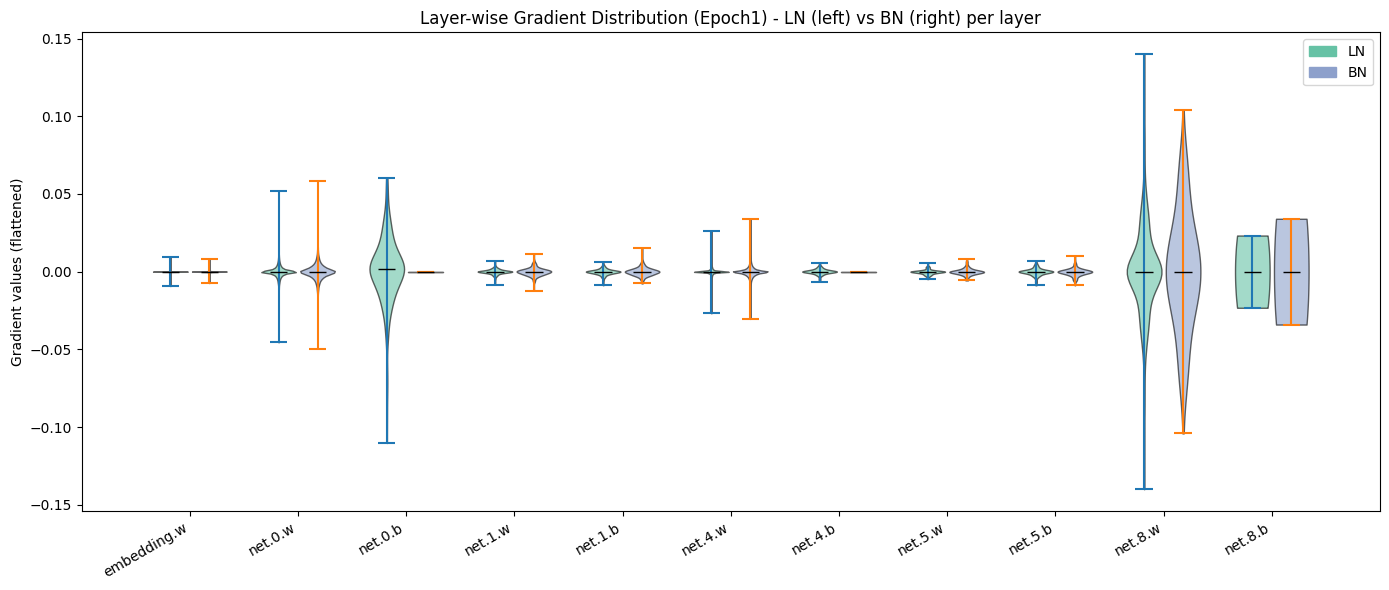

Saved violin plot to: bn_ln_violin_out/layerwise_grad_violin_epoch1.png
Plotting epoch_mid - LN vs BN


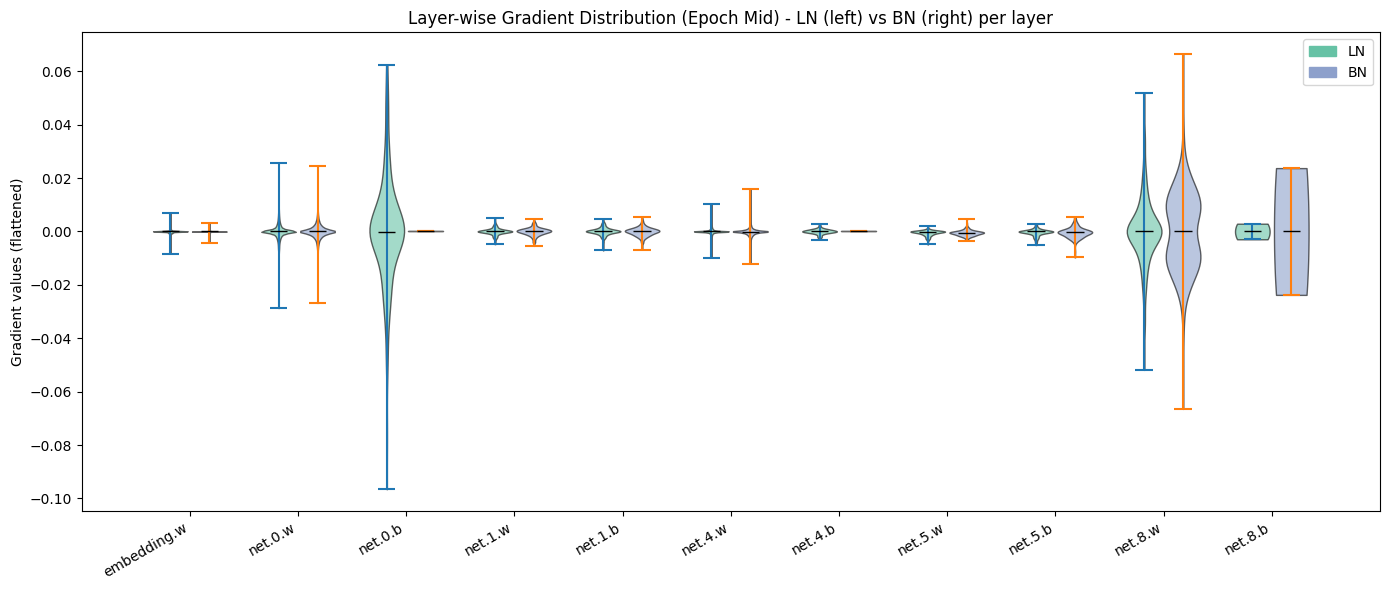

Saved violin plot to: bn_ln_violin_out/layerwise_grad_violin_epoch_mid.png
Plotting epoch_final - LN vs BN


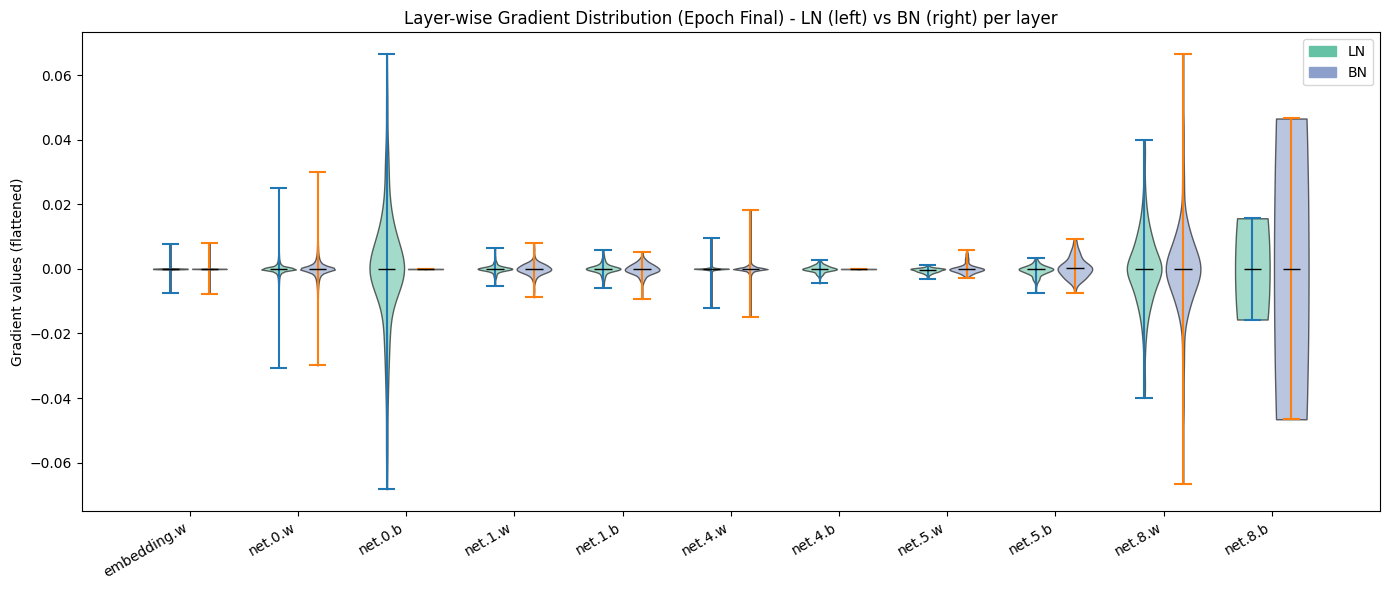

Saved violin plot to: bn_ln_violin_out/layerwise_grad_violin_epoch_final.png
All done. Plots saved to bn_ln_violin_out


In [10]:

print("Device:", DEVICE)
print("Starting LN run...")
res_ln = train_and_record(norm_type='ln', batch_size=BASE_BATCH_SIZE, epochs=EPOCHS, record_layers=True)
print("\nStarting BN run...")
res_bn = train_and_record(norm_type='bn', batch_size=BASE_BATCH_SIZE, epochs=EPOCHS, record_layers=True)


param_names = [name for name, _ in res_ln['model'].named_parameters()]


checkpoints = ['epoch1', 'epoch_mid', 'epoch_final']
for cp in checkpoints:
    ln_samples = res_ln['layer_grads_samples'].get(cp, None)
    bn_samples = res_bn['layer_grads_samples'].get(cp, None)
    if ln_samples is None or bn_samples is None:
        print("Skipping checkpoint", cp, " — missing data for LN or BN")
        continue

    print(f"Plotting {cp} - LN vs BN")
    outpath = os.path.join(OUT_DIR, f"layerwise_grad_violin_{cp}.png")
    title = f"Layer-wise Gradient Distribution ({cp.replace('_',' ').title()}) - LN (left) vs BN (right) per layer"
    plot_layerwise_ln_vs_bn(ln_samples, bn_samples, param_names, title, outpath, figsize=(14,6))

print("All done. Plots saved to", OUT_DIR)

Saved: bn_ln_violin_out/loss_vs_epoch_combined.png


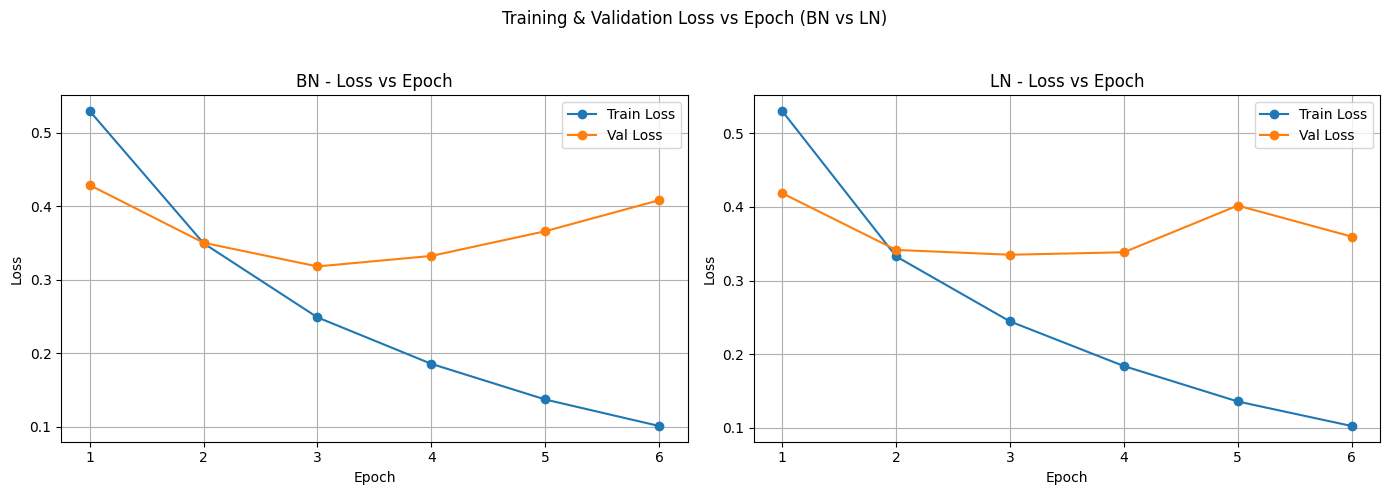

Saved: bn_ln_violin_out/acc_vs_epoch_combined.png


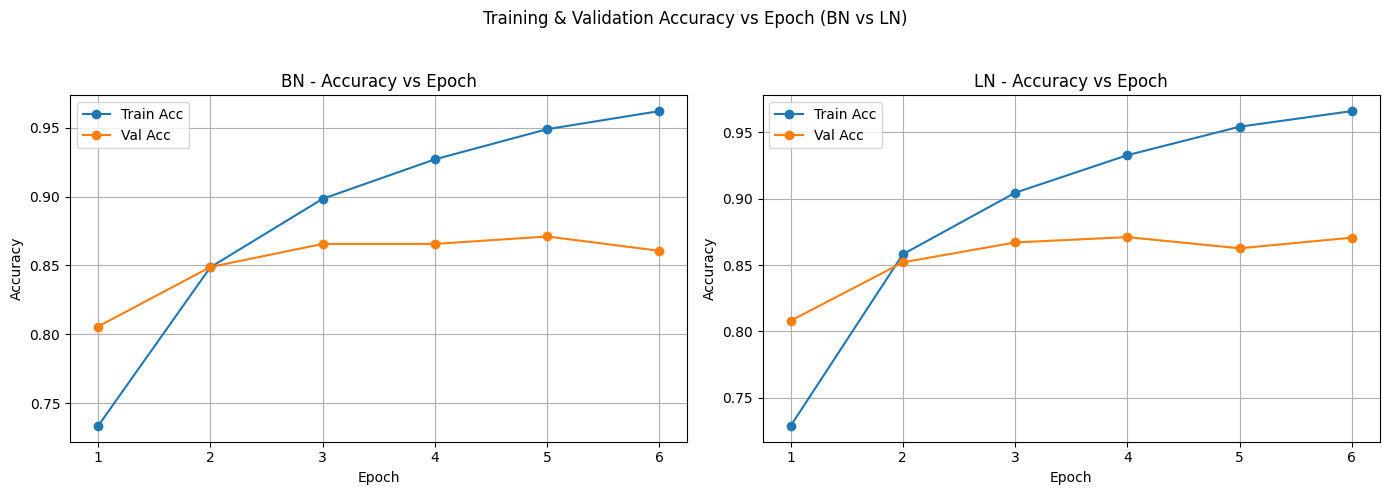

Saved: bn_ln_violin_out/batch_size_sensitivity.png


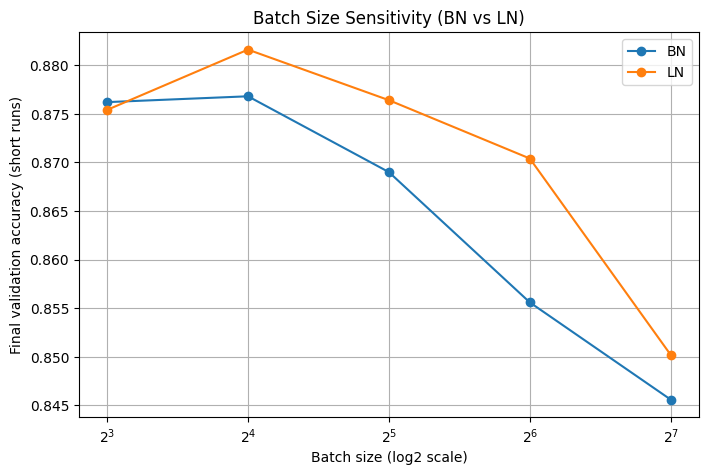

Saved: bn_ln_violin_out/global_grad_norm_vs_step.png


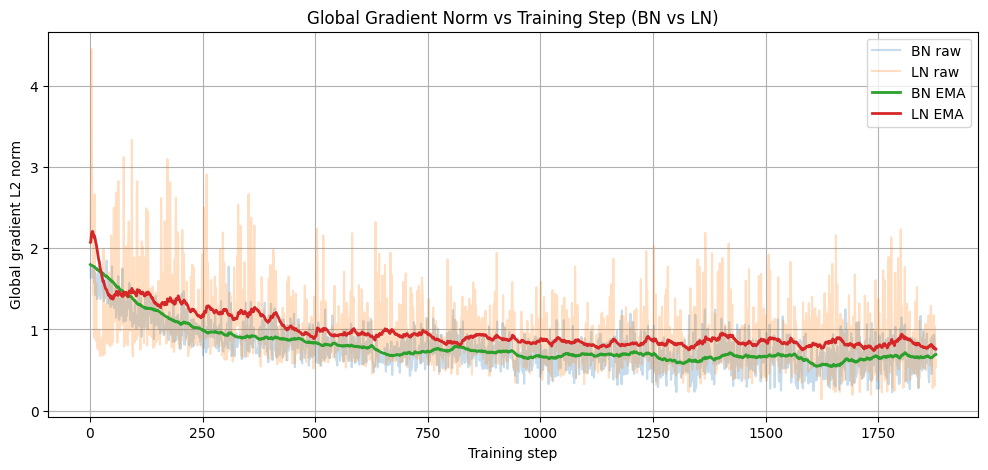

All requested plots saved to bn_ln_violin_out


In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np


OUT_DIR = "bn_ln_violin_out"
os.makedirs(OUT_DIR, exist_ok=True)


if 'res_bn' not in globals() or 'res_ln' not in globals():
    raise RuntimeError("res_bn and/or res_ln not found in globals. Run the training cells first (which return res_bn and res_ln).")


bn = res_bn
ln = res_ln


def ensure_ema(res, alpha=0.03):
    if 'grad_ema' in res and res['grad_ema'] is not None and len(res['grad_ema'])==len(res['grad_norms']):
        return res['grad_ema']
    ema = []
    for i,g in enumerate(res['grad_norms']):
        if i==0: ema.append(g)
        else: ema.append(alpha*g + (1-alpha)*ema[-1])
    return ema

if 'grad_ema' not in bn or bn.get('grad_ema') is None:
    bn['grad_ema'] = ensure_ema(bn)
if 'grad_ema' not in ln or ln.get('grad_ema') is None:
    ln['grad_ema'] = ensure_ema(ln)


def plot_loss_vs_epoch(bn_res, ln_res, outdir=OUT_DIR):
    epochs_bn = range(1, len(bn_res['train_loss'])+1)
    epochs_ln = range(1, len(ln_res['train_loss'])+1)

    fig, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].plot(epochs_bn, bn_res['train_loss'], label='Train Loss', marker='o')
    axs[0].plot(epochs_bn, bn_res['val_loss'], label='Val Loss', marker='o')
    axs[0].set_title('BN - Loss vs Epoch'); axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Loss'); axs[0].legend(); axs[0].grid(True)

    axs[1].plot(epochs_ln, ln_res['train_loss'], label='Train Loss', marker='o')
    axs[1].plot(epochs_ln, ln_res['val_loss'], label='Val Loss', marker='o')
    axs[1].set_title('LN - Loss vs Epoch'); axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Loss'); axs[1].legend(); axs[1].grid(True)

    fig.suptitle('Training & Validation Loss vs Epoch (BN vs LN)')
    fig.tight_layout(rect=[0,0,1,0.95])
    p = os.path.join(outdir, "loss_vs_epoch_combined.png")
    fig.savefig(p, dpi=150)
    print("Saved:", p)
    plt.show()


def plot_acc_vs_epoch(bn_res, ln_res, outdir=OUT_DIR):
    epochs_bn = range(1, len(bn_res['train_acc'])+1)
    epochs_ln = range(1, len(ln_res['train_acc'])+1)

    fig, axs = plt.subplots(1,2, figsize=(14,5))
    axs[0].plot(epochs_bn, bn_res['train_acc'], label='Train Acc', marker='o')
    axs[0].plot(epochs_bn, bn_res['val_acc'], label='Val Acc', marker='o')
    axs[0].set_title('BN - Accuracy vs Epoch'); axs[0].set_xlabel('Epoch'); axs[0].set_ylabel('Accuracy'); axs[0].legend(); axs[0].grid(True)

    axs[1].plot(epochs_ln, ln_res['train_acc'], label='Train Acc', marker='o')
    axs[1].plot(epochs_ln, ln_res['val_acc'], label='Val Acc', marker='o')
    axs[1].set_title('LN - Accuracy vs Epoch'); axs[1].set_xlabel('Epoch'); axs[1].set_ylabel('Accuracy'); axs[1].legend(); axs[1].grid(True)

    fig.suptitle('Training & Validation Accuracy vs Epoch (BN vs LN)')
    fig.tight_layout(rect=[0,0,1,0.95])
    p = os.path.join(outdir, "acc_vs_epoch_combined.png")
    fig.savefig(p, dpi=150)
    print("Saved:", p)
    plt.show()


def plot_batch_sensitivity(sweep_results, outdir=OUT_DIR):
    if 'sweep_results' not in globals():
        print("sweep_results not found in globals. Skipping batch-size sensitivity plot.")
        return
    sr = sweep_results
    plt.figure(figsize=(8,5))
    for norm in ['bn','ln']:
        if norm not in sr or len(sr[norm])==0:
            continue
        bs = [x['batch_size'] for x in sr[norm]]
        accs = [x.get('val_acc', x.get('test_acc', None)) for x in sr[norm]]
        plt.plot(bs, accs, marker='o', label=norm.upper())
    plt.xscale('log', base=2)
    plt.xlabel('Batch size (log2 scale)')
    plt.ylabel('Final validation accuracy (short runs)')
    plt.title('Batch Size Sensitivity (BN vs LN)')
    plt.legend(); plt.grid(True)
    p = os.path.join(outdir, "batch_size_sensitivity.png")
    plt.savefig(p, dpi=150)
    print("Saved:", p)
    plt.show()


def plot_global_grad_vs_step(bn_res, ln_res, outdir=OUT_DIR, logscale=False, raw_alpha=0.25):
    plt.figure(figsize=(12,5))
    plt.plot(bn_res['grad_norms_steps'], bn_res['grad_norms'], alpha=raw_alpha, label='BN raw')
    plt.plot(ln_res['grad_norms_steps'], ln_res['grad_norms'], alpha=raw_alpha, label='LN raw')
    if 'grad_ema' in bn_res:
        plt.plot(bn_res['grad_norms_steps'], bn_res['grad_ema'], linewidth=2, label='BN EMA')
    if 'grad_ema' in ln_res:
        plt.plot(ln_res['grad_norms_steps'], ln_res['grad_ema'], linewidth=2, label='LN EMA')
    plt.xlabel('Training step')
    plt.ylabel('Global gradient L2 norm')
    plt.title('Global Gradient Norm vs Training Step (BN vs LN)')
    plt.legend(); plt.grid(True)
    if logscale:
        plt.yscale('log')
    p = os.path.join(outdir, "global_grad_norm_vs_step.png")
    plt.savefig(p, dpi=150)
    print("Saved:", p)
    plt.show()


plot_loss_vs_epoch(bn, ln, outdir=OUT_DIR)
plot_acc_vs_epoch(bn, ln, outdir=OUT_DIR)
plot_batch_sensitivity(globals().get('sweep_results', None), outdir=OUT_DIR)
plot_global_grad_vs_step(bn, ln, outdir=OUT_DIR, logscale=False)

print("All requested plots saved to", OUT_DIR)

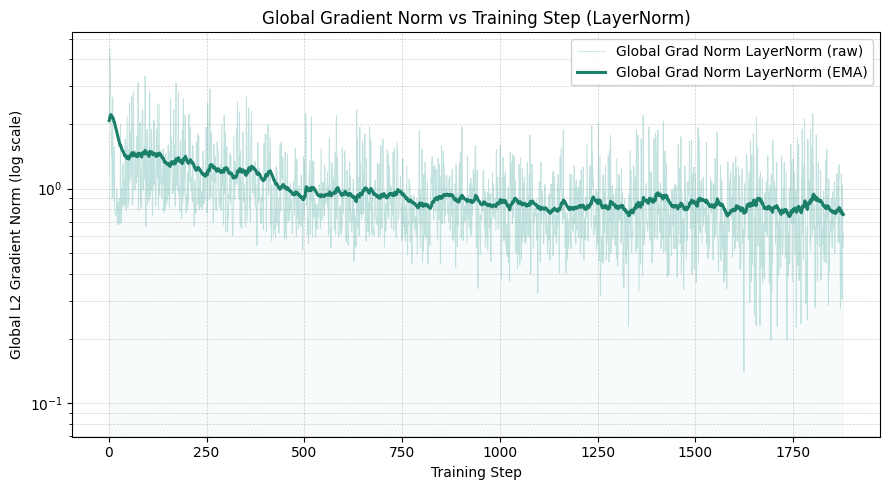

Saved: bn_ln_violin_out/global_grad_norm_layernorm.png


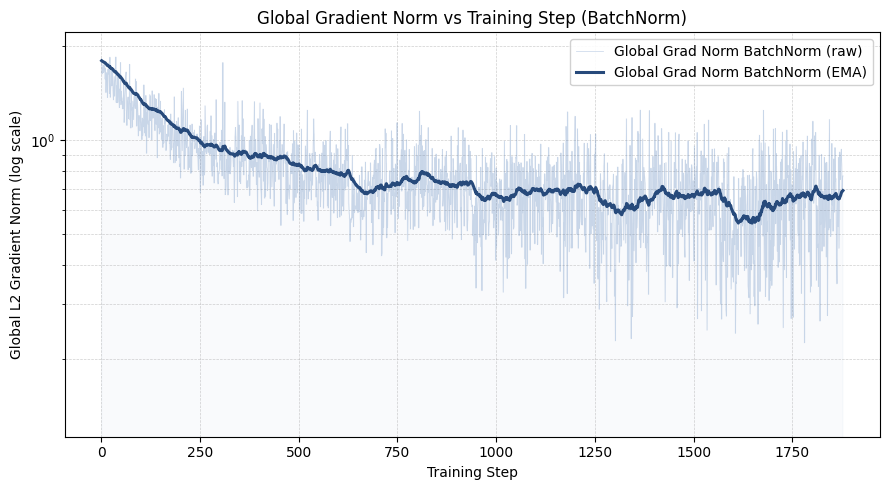

Saved: bn_ln_violin_out/global_grad_norm_batchnorm.png


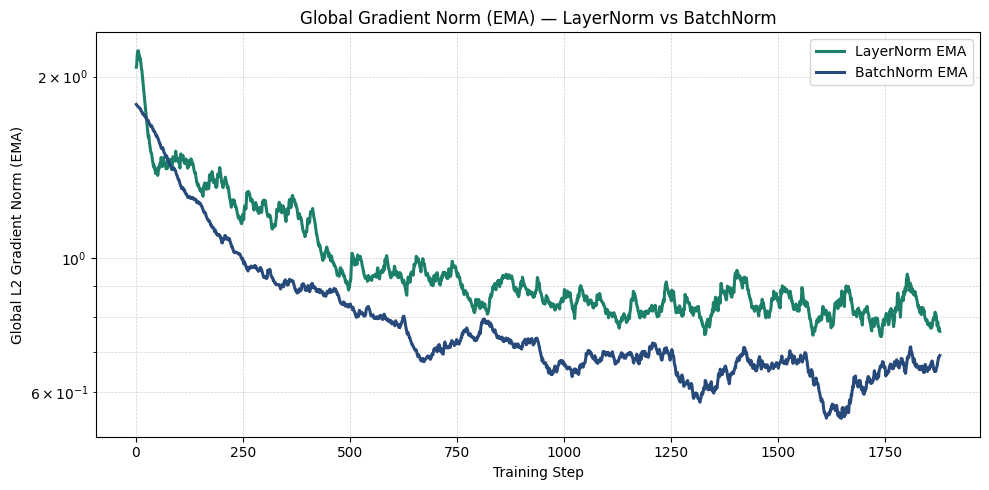

Saved: bn_ln_violin_out/global_grad_norm_ema_comparison.png


In [12]:

import os
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "bn_ln_violin_out"
os.makedirs(OUT_DIR, exist_ok=True)


if 'res_ln' not in globals() or 'res_bn' not in globals():
    raise RuntimeError("res_ln and res_bn must exist. Run the training cells first and return those dicts.")

def ensure_ema(res, alpha=0.03):
    """Return EMA array for res. Compute if missing or length mismatch."""
    g = np.array(res.get('grad_norms', []), dtype=float)
    if g.size == 0:
        return np.array([])
    em = np.array(res.get('grad_ema', []), dtype=float)
    if em.size == g.size:
        return em

    ema = np.empty_like(g)
    ema[0] = g[0]
    for i in range(1, g.size):
        ema[i] = alpha * g[i] + (1 - alpha) * ema[i-1]
    return ema

def safe_min_positive(arr):
    """Return a small positive floor so log scale doesn't break (avoid zeros)."""
    arr = np.array(arr, dtype=float)
    pos = arr[arr > 0]
    if pos.size == 0:
        return 1e-6
    return max(pos.min() * 0.5, 1e-6)

def plot_single_norm(res, label, outpath, color_raw='#1f77b4', color_ema='#004c99', logy=True):
    steps = res.get('grad_norms_steps', None)
    raw = np.array(res.get('grad_norms', []), dtype=float)
    ema = ensure_ema(res)
    if steps is None or raw.size == 0:
        raise RuntimeError(f"{label}: no gradient norm data found in result dict.")

    steps = np.array(steps, dtype=int)

    floor = safe_min_positive(raw)
    raw_plot = np.maximum(raw, floor)
    ema_plot = np.maximum(ema, floor) if ema.size>0 else None

    plt.figure(figsize=(9,5))
    plt.plot(steps, raw_plot, linewidth=0.6, alpha=0.25, color=color_raw, label=f"Global Grad Norm {label} (raw)")
    plt.fill_between(steps, raw_plot, step='pre', alpha=0.03, color=color_raw)


    if ema_plot is not None:
        plt.plot(steps, ema_plot, linewidth=2.2, color=color_ema, label=f"Global Grad Norm {label} (EMA)")

    plt.xlabel("Training Step")
    plt.ylabel("Global L2 Gradient Norm (log scale)" if logy else "Global L2 Gradient Norm")
    plt.title(f"Global Gradient Norm vs Training Step ({label})")
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.6)

    if logy:
        plt.yscale('log')
        y_min = floor
        y_max = max(raw_plot.max(), ema_plot.max() if ema_plot is not None else 0.0) * 1.2
        if y_max <= y_min:
            y_max = y_min * 10.0
        plt.ylim(y_min, y_max)


    leg = plt.legend(loc='upper right', frameon=True)
    leg.get_frame().set_facecolor("white")
    leg.get_frame().set_alpha(0.9)

    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    print("Saved:", outpath)

plot_single_norm(res_ln, "LayerNorm", os.path.join(OUT_DIR, "global_grad_norm_layernorm.png"),
                 color_raw='#2a9d8f', color_ema='#1b7f6a', logy=True)
plot_single_norm(res_bn, "BatchNorm", os.path.join(OUT_DIR, "global_grad_norm_batchnorm.png"),
                 color_raw='#4575b4', color_ema='#274a7b', logy=True)

def plot_combined_ema(res_ln, res_bn, outpath):
    ln_steps = np.array(res_ln['grad_norms_steps'], dtype=int)
    ln_ema = ensure_ema(res_ln)
    bn_steps = np.array(res_bn['grad_norms_steps'], dtype=int)
    bn_ema = ensure_ema(res_bn)
    if ln_ema.size==0 or bn_ema.size==0:
        print("One of the EMA traces is missing; skipping combined EMA plot.")
        return
    plt.figure(figsize=(10,5))
    plt.plot(ln_steps, ln_ema, label='LayerNorm EMA', linewidth=2.2, color='#1b7f6a')
    plt.plot(bn_steps, bn_ema, label='BatchNorm EMA', linewidth=2.2, color='#274a7b')
    plt.xlabel("Training Step")
    plt.ylabel("Global L2 Gradient Norm (EMA)")
    plt.title("Global Gradient Norm (EMA) — LayerNorm vs BatchNorm")
    plt.yscale('log')
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.6)
    plt.legend(frameon=True).get_frame().set_facecolor('white')
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    print("Saved:", outpath)

plot_combined_ema(res_ln, res_bn, os.path.join(OUT_DIR, "global_grad_norm_ema_comparison.png"))

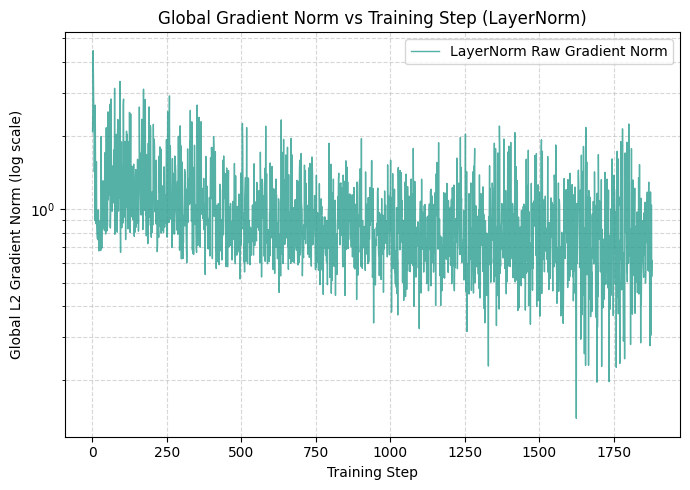

Saved: bn_ln_violin_out/global_grad_norm_raw_layernorm.png


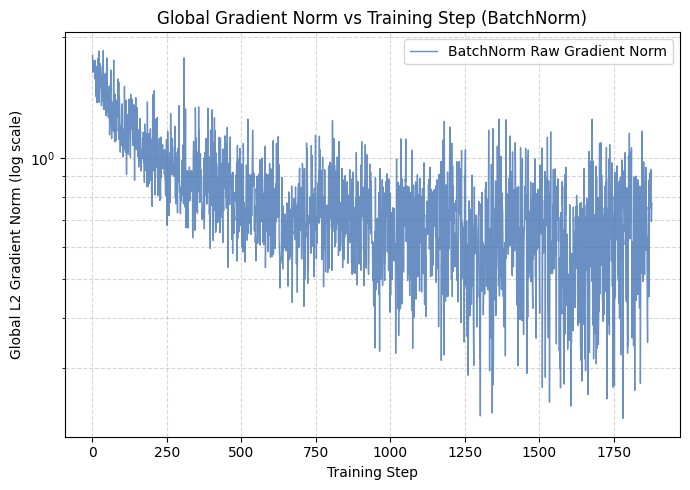

Saved: bn_ln_violin_out/global_grad_norm_raw_batchnorm.png


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os

OUT_DIR = "bn_ln_violin_out"
os.makedirs(OUT_DIR, exist_ok=True)

def plot_raw_global_grad(res, label, outpath,
                         color="#1f77b4",
                         linewidth=1.0,
                         alpha=0.8):
    """
    res: dict containing 'grad_norms' and 'grad_norms_steps'
    label: 'LayerNorm' or 'BatchNorm'
    """
    steps = np.array(res["grad_norms_steps"], dtype=int)
    raw = np.array(res["grad_norms"], dtype=float)


    raw_safe = np.clip(raw, 1e-8, None)

    plt.figure(figsize=(7,5))
    plt.plot(steps, raw_safe,
             color=color,
             linewidth=linewidth,
             alpha=alpha,
             label=f"{label} Raw Gradient Norm")

    plt.yscale("log")
    plt.xlabel("Training Step")
    plt.ylabel("Global L2 Gradient Norm (log scale)")
    plt.title(f"Global Gradient Norm vs Training Step ({label})")
    plt.grid(True, which="both", ls="--", alpha=0.5)

    plt.legend(loc="upper right", frameon=True)
    plt.tight_layout()
    plt.savefig(outpath, dpi=150)
    plt.show()
    print("Saved:", outpath)



plot_raw_global_grad(
    res_ln,
    label="LayerNorm",
    outpath=os.path.join(OUT_DIR, "global_grad_norm_raw_layernorm.png"),
    color="#2a9d8f"
)


plot_raw_global_grad(
    res_bn,
    label="BatchNorm",
    outpath=os.path.join(OUT_DIR, "global_grad_norm_raw_batchnorm.png"),
    color="#4575b4"
)
